# Download Dataset from Kaggle

In [ ]:
!kaggle datasets download -d wenchik/gender-labelled-panoramic-dental-xray

Dataset URL: https://www.kaggle.com/datasets/wenchik/gender-labelled-panoramic-dental-xray
License(s): MIT
100% 111M/111M [00:06<00:00, 23.0MB/s]
100% 111M/111M [00:06<00:00, 16.9MB/s]


In [ ]:
!unzip gender-labelled-panoramic-dental-xray.zip

Archive:  gender-labelled-panoramic-dental-xray.zip
  inflating: Radiographs/test/female/female.441.JPG  
  inflating: Radiographs/test/female/female.442.JPG  
  inflating: Radiographs/test/female/female.443.JPG  
  inflating: Radiographs/test/female/female.444.JPG  
  inflating: Radiographs/test/female/female.445.JPG  
  inflating: Radiographs/test/female/female.446.JPG  
  inflating: Radiographs/test/female/female.447.JPG  
  inflating: Radiographs/test/female/female.448.JPG  
  inflating: Radiographs/test/female/female.449.JPG  
  inflating: Radiographs/test/female/female.450.JPG  
  inflating: Radiographs/test/female/female.451.JPG  
  inflating: Radiographs/test/female/female.452.JPG  
  inflating: Radiographs/test/female/female.453.JPG  
  inflating: Radiographs/test/female/female.454.JPG  
  inflating: Radiographs/test/female/female.455.JPG  
  inflating: Radiographs/test/female/female.456.JPG  
  inflating: Radiographs/test/female/female.457.JPG  
  inflating: Radiographs/test/

# Saving Dataset for later use 

In [ ]:
import os
source_folder = '/content/Radiographs'
destination_folder = '/content/drive/MyDrive/Gender_Dataset'

!cp -r "{source_folder}" "{destination_folder}"

# Imports Necessary Modules

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Paths

In [3]:
data_dir = "/content/drive/MyDrive/Gender_Dataset/Radiographs"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Dataset Distribution: Train Set

In [4]:
print("Train set:\n========================================")
print(f"Male={len(os.listdir(os.path.join(train_dir, 'male')))} images")
print(f"Female={len(os.listdir(os.path.join(train_dir, 'female')))} images")

Train set:
Male=343 images
Female=343 images


# Dataset Distribution: Test Set

In [5]:
print("Test set:\n========================================")
print(f"Male={len(os.listdir(os.path.join(test_dir, 'male')))} images")
print(f"Female={len(os.listdir(os.path.join(test_dir, 'female')))} images")

Test set:
Male=48 images
Female=49 images


# Dataset Distribution: Validation Set

In [6]:
print("Validation set:\n========================================")
print(f"Male={len(os.listdir(os.path.join(valid_dir, 'male')))} images")
print(f"Female={len(os.listdir(os.path.join(valid_dir, 'female')))} images")

Validation set:
Male=98 images
Female=98 images


# Number of Images in each Class (Train, Validation, Test)

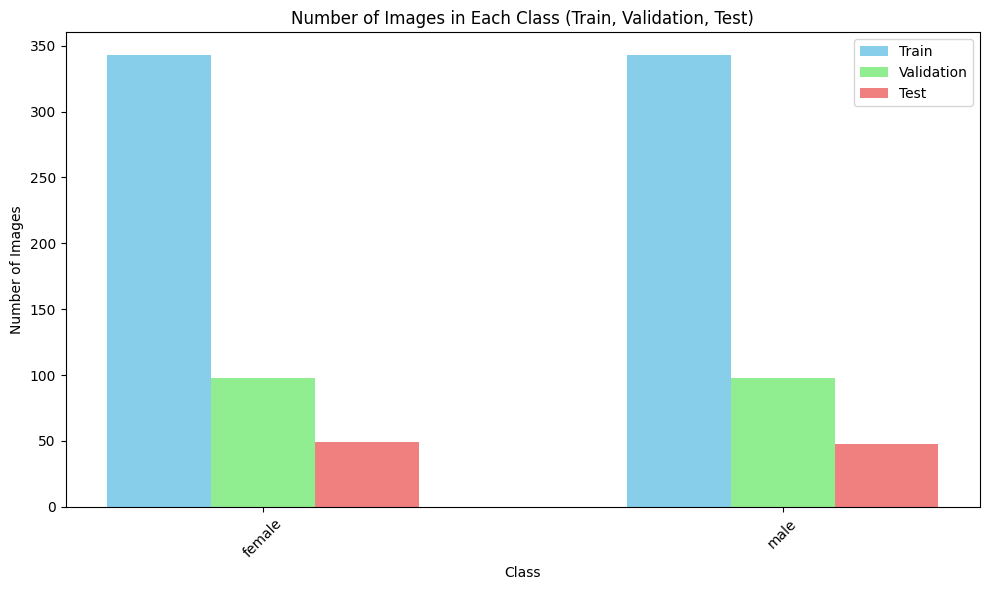

In [7]:
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_images_in_classes(train_dir)
valid_counts = count_images_in_classes(valid_dir)
test_counts = count_images_in_classes(test_dir)
all_classes = list(train_counts.keys())
train_values = [train_counts.get(cls, 0) for cls in all_classes]
valid_values = [valid_counts.get(cls, 0) for cls in all_classes]
test_values = [test_counts.get(cls, 0) for cls in all_classes]
x = np.arange(len(all_classes))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, train_values, width, label='Train', color='skyblue')
plt.bar(x, valid_values, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_values, width, label='Test', color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class (Train, Validation, Test)')
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Hyperparameters

In [8]:
BATCH_SIZE = 32
EPOCHS = 10
ROTATION_RANGE = 5
WIDTH_SHIFT_RANGE = 0.02
HEIGHT_SHIFT_RANGE = 0.02
ZOOM_RANGE = 0.02
SHEAR_RANGE=0.02
BRIGHTNESS_RANGE = [0.95, 1.05]


# Image Preprocessing Pipeline

In [9]:
target_size = (224, 224)

def preprocessing(image):
    """
    Perform preprocessing including :
        Convert grayscale to RGB ,
        resizing,
        normalization,
        contrast adjustment,
        Gaussian noise
    """

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0

    contrast_factor = np.random.uniform(0.9, 1.1)
    image = tf.image.adjust_contrast(image, contrast_factor).numpy()

    gaussian_noise_stddev = np.random.uniform(0.01, 0.03)
    gaussian_noise = np.random.normal(0, gaussian_noise_stddev, image.shape)
    image = np.clip(image + gaussian_noise, 0, 1)

    return image

# Data Augmentation

In [39]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=BATCH_SIZE, class_mode='binary', shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=target_size, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

images_batch, labels_batch = next(train_generator)

print(f"Sample shuffled labels in a batch: {labels_batch[:10]}")

Found 686 images belonging to 2 classes.
Found 196 images belonging to 2 classes.
Found 97 images belonging to 2 classes.
Sample shuffled labels in a batch: [1. 0. 0. 0. 0. 0. 1. 1. 1. 0.]


# Visualizing Sample Images with Labels

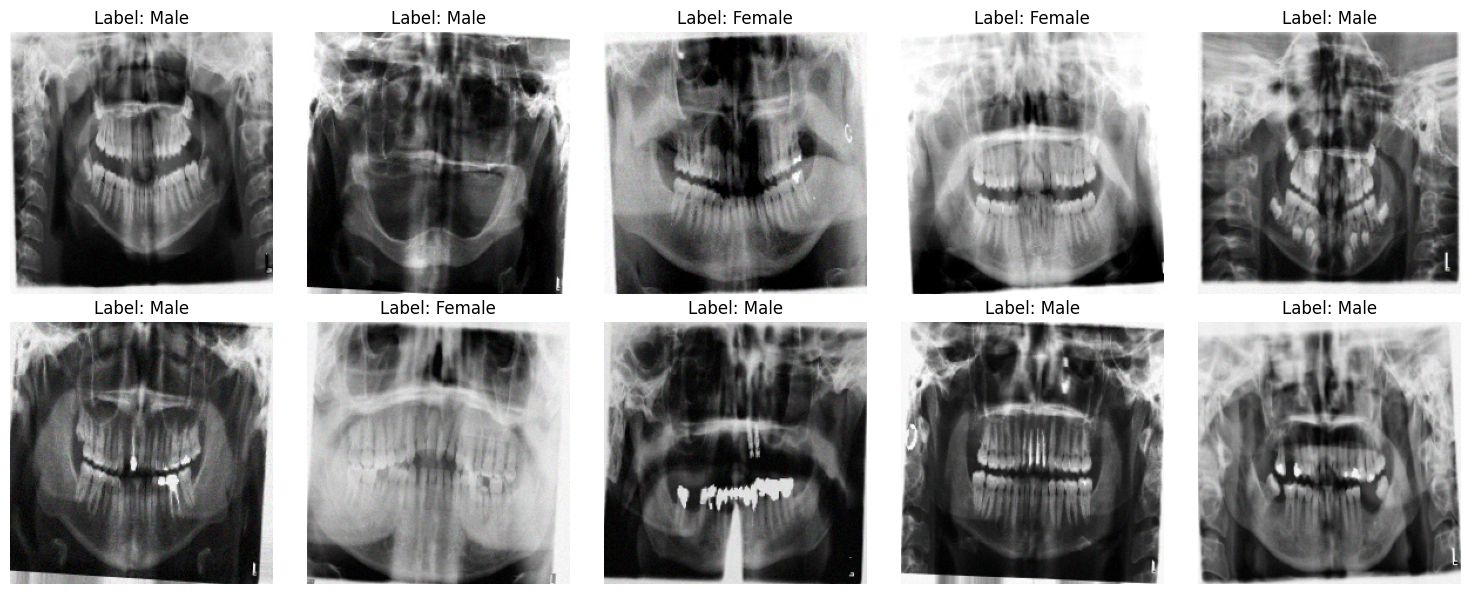

In [38]:
label_mapping = {0: 'Female', 1: 'Male'}
def plot_images_with_labels(generator, label_mapping, num_images=10, images_per_row=5):
    images, labels = next(generator)
    num_images_in_batch = images.shape[0]
    num_images = min(num_images, num_images_in_batch)
    num_rows = int(np.ceil(num_images / images_per_row))
    indices = np.random.choice(num_images_in_batch, num_images, replace=False)

    plt.figure(figsize=(images_per_row * 3, num_rows * 3))
    for i, index in enumerate(indices):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[index])
        plt.axis('off')

        label = labels[index]
        class_label = label_mapping.get(int(label), 'Unknown')
        plt.title(f'Label: {class_label}')

    plt.tight_layout()
    plt.show()


plot_images_with_labels(train_generator, label_mapping, num_images=10, images_per_row=5)

# InceptionV3 Model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:200]:
    layer.trainable = False

for layer in base_model.layers[200:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5479 - loss: 1.0144 - val_accuracy: 0.8520 - val_loss: 0.4169
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7781 - loss: 0.4792 - val_accuracy: 0.8673 - val_loss: 0.3283
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8602 - loss: 0.3347 - val_accuracy: 0.8418 - val_loss: 0.3500
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8372 - loss: 0.3296 - val_accuracy: 0.8724 - val_loss: 0.3229
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8873 - loss: 0.2913 - val_accuracy: 0.9031 - val_loss: 0.2913
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8690 - loss: 0.2998 - val_accuracy: 0.8724 - val_loss: 0.2931
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9098 - loss: 0.2373 - val_accuracy: 0.8163 - val_loss: 0.3664
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.907

# Model Summary

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,377,189 (89.18 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,049,604 (4.00 MB)

# Training vs. Validation Accuracy Over Epochs

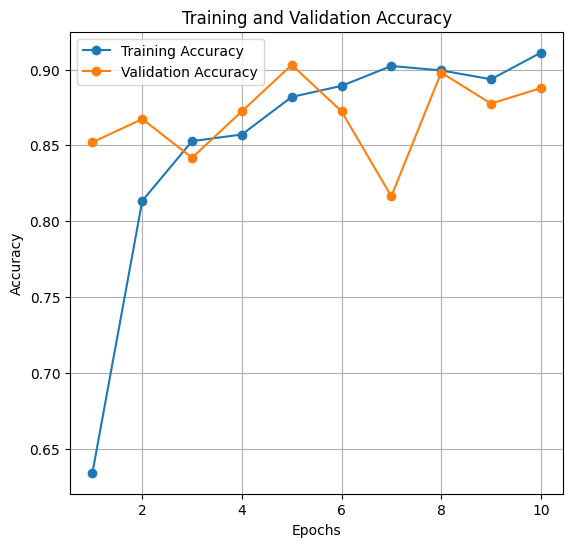

In [30]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Training vs. Validation Loss Over Epochs

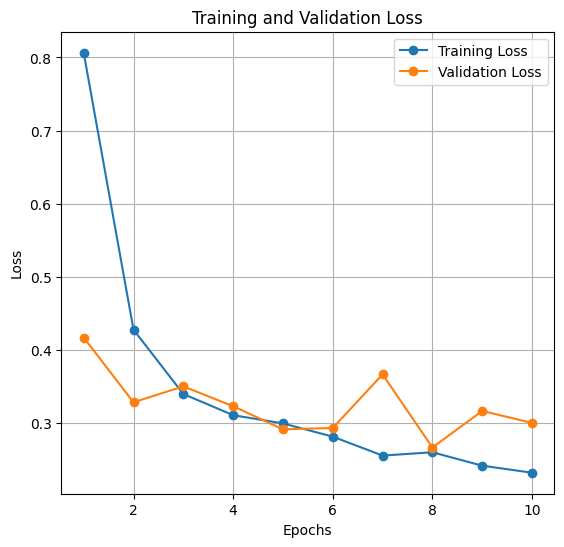

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)


plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

#  Evaluating the Model Performance

In [32]:
test_loss, test_accuracy = model.evaluate(train_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9449 - loss: 0.1854
Test Accuracy: 93.59%


# Classification Report

In [33]:
from sklearn.metrics import classification_report
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()

test_labels = test_generator.classes
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=['Female', 'Male']))


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
Classification Report:
              precision    recall  f1-score   support

      Female       0.92      0.90      0.91        49
        Male       0.90      0.92      0.91        48

    accuracy                           0.91        97
   macro avg       0.91      0.91      0.91        97
weighted avg       0.91      0.91      0.91        97



# Confusion Matrix

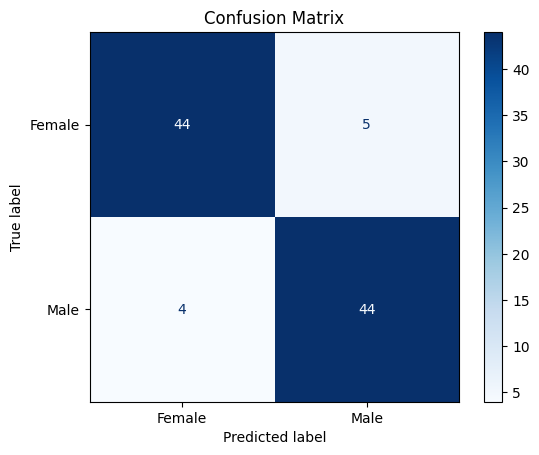

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


# ROC Curve

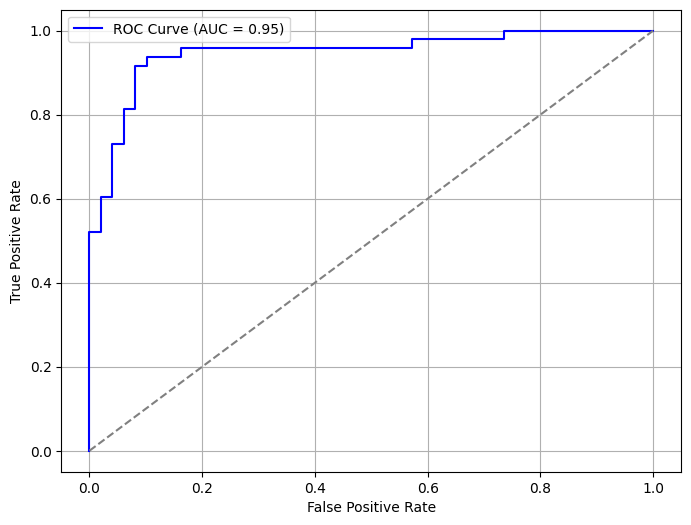

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(test_labels, Y_pred)
auc_score = roc_auc_score(test_labels, Y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Saving the Trained Model

In [36]:
model.save('Gender_InceptionV3(93.6).h5')
source_folder = '/content/Gender_InceptionV3(93.6).h5'
destination_folder = '/content/drive/MyDrive/saved_for_me'
!cp -r "{source_folder}" "{destination_folder}"
if os.path.exists(destination_folder):
    print(f"Dataset successfully saved to {destination_folder}")
else:
    print("Failed to save the dataset to Google Drive.")

Dataset successfully saved to /content/drive/MyDrive/saved_for_me


# Load Trained Model and Predict Gender Class from a New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Gender: Male
Prediction Confidence: 0.80


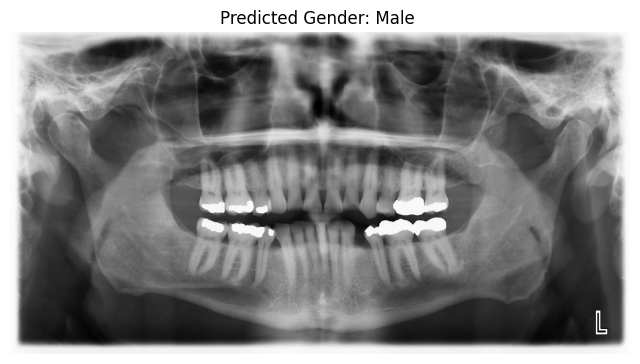

In [37]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt

model_path = '/content/drive/MyDrive/saved_for_me/Gender_InceptionV3(93.6).h5'
image_path = '/content/drive/MyDrive/Gender_Dataset/Radiographs/test/male/male.441.JPG'

model = load_model(model_path)

target_size = (224, 224)
def preprocessing(image):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0

    contrast_factor = np.random.uniform(0.9, 1.1)
    image = tf.image.adjust_contrast(image, contrast_factor).numpy()

    return image

def predict_image(image_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")

    image = preprocessing(image)

    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)

    predicted_class = 1 if prediction[0] >= 0.5 else 0
    return predicted_class, prediction[0]

predicted_class, prediction_score = predict_image(image_path, model)

class_labels = ['Female', 'Male']

print(f"Predicted Gender: {class_labels[predicted_class]}")
print(f"Prediction Confidence: {prediction_score[0]:.2f}")

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Gender: {class_labels[predicted_class]} ")
plt.axis('off')
plt.show()
